# **1. Instalação**

In [1]:
#%pip install yfinance scikit-learn matplotlib pandas ipywidgets tqdm river

# **2. Importação das Bibliotecas Auxiliares**

In [2]:
from preprocessamento.SeriesProcessor import SeriesProcessor
from frameworkDetector.framework_detector import FrameworkDetector # Sua classe principal
from utils.StreamProcessor import StreamProcessor # Seu processador de stream
from utils import Visualizer
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import time

from detectores.KSWINDetector import KSWINDetector
from regressores.modelosOffline.RandomForestModelo import RandomForestModelo

# **3. Importação das Classes do Framework**

In [3]:
from preprocessamento.SeriesProcessor import SeriesProcessor
from frameworkDetector.framework_detector import FrameworkDetector
from utils.StreamProcessor import StreamProcessor
from utils import Visualizer

# **4. Importação de Detectores**

In [4]:
from detectores.ADWINDetector import ADWINDetector
from detectores.DDMDetector import DDMDetector
from detectores.EDDMDetector import EDDMDetector
from detectores.FHDDMDetector import FHDDMDetector
from detectores.HDDM_ADetector import HDDM_ADetector
from detectores.PageHinkleyDetector import PageHinkleyDetector
from detectores.HDDM_WDetector import HDDM_WDetector
from detectores.KSWINDetector import KSWINDetector

# **5. Importação de Modeos** 

In [5]:
from regressores.modelosOffline.LinearRegressionModelo import LinearRegressionModelo
from regressores.modelosOffline.KneighborsRegressorModelo import KNeighborsRegressorModelo
from regressores.modelosOffline.LassoRegressionModelo import LassoRegressionModelo
from regressores.modelosOffline.RidgeRegressionModelo import RidgeRegressionModelo
from regressores.modelosOffline.SVRModelo import SVRModelo
from regressores.modelosOffline.RandomForestModelo import RandomForestModelo
from regressores.modelosOffline.MLPRegressorModelo import MLPRegressorModelo


# **6. Lista de Séries Temporais**

In [6]:
# Lista de séries temporais disponíveis
series = [
    "AAPL",
    "B3SA3.SA",
    "^IXIC",
    "^DJI",
    "^GSPC",
    "^BVSP",
    "USDBRL=X"
]

# **7. Definição de Parâmetros**

In [7]:
lags = 5
serie_escolhida = series[5]  # ^BVSP
print(f"Processando série: {serie_escolhida}")

# Parâmetros do framework
tamanho_janela = 200
intervalo_adicao_pool = 30
observacoes_novo_conceito = 55
detector_escolhido = "KSWIN"
tipo_modelo_inicial_global = RandomForestModelo
max_pool_size = 5
min_diversidade_erro = 0.05
n_clusters_regimes = 5
limiar_degradacao = 0.15
threshold_melhoria_alerta = 0.94
metrics_interval = 50
min_samples_for_metrics = 5

Processando série: ^BVSP


# **8. Obtenção e Pré-processamento dos Dados**

In [8]:
# Baixando os dados
serie_temporal = SeriesProcessor.baixar_dados(serie_escolhida)

# Normalizando a série temporal
serie_temporal_normalizada = SeriesProcessor.normalizar_serie(serie_temporal)
print(f"Shape da série após normalização: {serie_temporal_normalizada.shape}")

# Gerando janelas temporais (features X e target Y)
X, Y = SeriesProcessor.criar_janela_temporal(serie_temporal_normalizada, lags)
print(f"Shape dos dados de entrada (X): {X.shape}")
print(f"Shape dos dados de saída (Y): {Y.shape}")

# Definindo tamanho do conjunto inicial de treinamento (20% dos dados)
initial_size = int(0.2 * len(X))
print(f"Tamanho do conjunto inicial de treinamento: {initial_size} amostras")

# Dividindo os dados em conjunto inicial e streaming
X_init = X[:initial_size]
y_init = Y[:initial_size]
X_stream = X[initial_size:]
Y_stream = Y[initial_size:]

print(f"Shape do X_init: {X_init.shape}")
print(f"Shape do Y_init: {y_init.shape}")
print(f"Shape do X_stream: {X_stream.shape}")
print(f"Shape do Y_stream: {Y_stream.shape}")

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

Shape da série após normalização: (1244, 1)
Shape dos dados de entrada (X): (1239, 5)
Shape dos dados de saída (Y): (1239, 1)
Tamanho do conjunto inicial de treinamento: 247 amostras
Shape do X_init: (247, 5)
Shape do Y_init: (247, 1)
Shape do X_stream: (992, 5)
Shape do Y_stream: (992, 1)


# **9. Inicialização do Framework - Modelo e Detector**

# 9.1 Treinar Modelo Inicial e Obter Scaler

In [9]:
print(f"Treinando modelo inicial ({tipo_modelo_inicial_global.__name__}) com {len(X_init)} amostras...")
modelo_inicial, scaler = FrameworkDetector.treinar_modelo_inicial(X_init, y_init, tipo_modelo=tipo_modelo_inicial_global)

if modelo_inicial is None:
    raise RuntimeError("Falha crítica: Não foi possível treinar o modelo inicial.")

/home/liedson/.pyenv/versions/3.12.6/lib/python3.12/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Treinando modelo inicial (RandomForestModelo) com 247 amostras...
Ajustando Scaler nos dados iniciais...
✓ Scaler ajustado e aplicado.

Iniciando treinamento do modelo inicial: RandomForestModelo...
  Modelo RandomForestModelo treinado com sucesso


# 9.2 Inicializar Estado do Framework

In [10]:
modelo_atual = modelo_inicial
pool_modelos = [modelo_inicial]
print(f"\nModelo inicial ativo: {modelo_atual.nome if hasattr(modelo_atual, 'nome') else tipo_modelo_inicial_global.__name__}")
print(f"Pool inicializado com 1 modelo.")


Modelo inicial ativo: RandomForestModelo
Pool inicializado com 1 modelo.


# 9.3 Inicializar Detector

In [11]:
print(f"Inicializando detector: {detector_escolhido}")
if detector_escolhido == "DDM":
    detector_wrapper = DDMDetector()
elif detector_escolhido == "ADWIN":
    detector_wrapper = ADWINDetector(delta=0.002)
elif detector_escolhido == "KSWIN":
    detector_wrapper = KSWINDetector(alpha=0.05, window_size=100)
elif detector_escolhido == "HDDM_W":
     detector_wrapper = HDDM_WDetector(drift_confidence=0.001, warning_confidence=0.005)
else:
    raise ValueError(f"Detector '{detector_escolhido}' não suportado ou não definido.")

Inicializando detector: KSWIN


# **10. Inicialização do StreamProcessor**

In [12]:
print(f"Inicializando janela de dados com as últimas {min(tamanho_janela, len(X_init))} amostras iniciais.")
janela_dados_recentes = list(zip(X_init[-tamanho_janela:], y_init[-tamanho_janela:]))

# Inicializando o processador de stream
print("Inicializando o StreamProcessor...")
processor = StreamProcessor(
    modelo_inicial=modelo_inicial,
    detector_wrapper=detector_wrapper,
    scaler=scaler,
    janela_dados_recentes=janela_dados_recentes,
    tipo_modelo_global=tipo_modelo_inicial_global,
    tamanho_janela=tamanho_janela,
    intervalo_adicao_pool=intervalo_adicao_pool,
    observacoes_novo_conceito=observacoes_novo_conceito,
    min_diversidade_erro=min_diversidade_erro,
    n_clusters_regimes=n_clusters_regimes,
    limiar_degradacao=limiar_degradacao,
    threshold_melhoria_alerta=threshold_melhoria_alerta,
    metrics_interval=metrics_interval,
    min_samples_for_metrics=min_samples_for_metrics,
    max_pool_size=max_pool_size
)
print("✓ Framework inicializado com sucesso.")

Inicializando janela de dados com as últimas 200 amostras iniciais.
Inicializando o StreamProcessor...
✓ Framework inicializado com sucesso.


# **11. Processamento do Stream**

In [13]:
print(f"\nIniciando processamento do stream com {len(X_stream)} amostras...")
start_time = time.time()

# Processamento do stream
results = processor.processar_stream(
    X_stream=X_stream,
    Y_stream=Y_stream,
    initial_size=initial_size,
    detector_escolhido=detector_escolhido
)

end_time = time.time()
print(f"✓ Processamento do stream concluído em {end_time - start_time:.2f} segundos.")



Iniciando processamento do stream com 992 amostras...

=== Iniciando Processamento do Stream ===
Processando 992 amostras...


Stream:   0%|          | 0/992 [00:00<?, ?it/s]

  ℹNão adicionando modelo: similar a um existente e não melhor
  ℹNão adicionando modelo: similar a um existente e não melhor

  🆕 Novo regime 1 detectado com modelo: RandomForestModelo
  ℹNão adicionando modelo: similar a um existente e não melhor

!!! Drift detectado no índice 347 (Detector: KSWIN, Regime: 1) !!!
  Avaliando 1 modelos do pool...
  Avaliando 1 modelos do pool na janela (200 amostras)...
  ✓ Melhor modelo do pool selecionado: RandomForestModelo (MSE: 0.0588)
  Desempenho: atual=0.0588, melhor do pool=0.0588
  Avaliando 1 modelos do pool na janela (200 amostras)...
  ✓ Melhor modelo do pool selecionado: RandomForestModelo (MSE: 0.0588)
  Pool reconfigurado após MUDANÇA: 1/1 modelos mantidos
  Iniciando coleta para retreino (55 amostras)

  🆕 Novo regime 3 detectado com modelo: RandomForestModelo

--- Retreinando Modelo com 55 obs. do novo conceito ---
  Treinando novo modelo (RandomForestModelo) com 56 amostras do novo conceito...
  Novo modelo (RandomForestModelo) trei

# **12. Extração de Resultados**

In [14]:
erros_predicao_stream = results['erros_predicao_stream']
predicoes_stream = results['predicoes_stream']
estados_detector_stream = results['estados_detector_stream']
pontos_drift_detectados = results['pontos_drift_detectados']
metricas_rmse_stream = results['metricas_rmse_stream']
metricas_mae_stream = results['metricas_mae_stream']
metricas_r2_stream = results['metricas_r2_stream']
modelo_ativo_ao_longo_do_tempo = results['modelo_ativo_ao_longo_do_tempo']
tamanho_pool_ao_longo_do_tempo = results['tamanho_pool_ao_longo_do_tempo']
pools_por_regime = results.get('pools_por_regime', {})

print(f"Total de drifts detectados: {len(pontos_drift_detectados)}")
print(f"Número final de modelos no pool principal: {len(processor.pool_modelos) if hasattr(processor, 'pool_modelos') else 'N/A'}")

Total de drifts detectados: 9
Número final de modelos no pool principal: N/A


# **13. Visualização de Resultados**

# 13.1 Análise Geral


Gerando visualizações dos resultados...

=== Análise dos Resultados do Stream ===


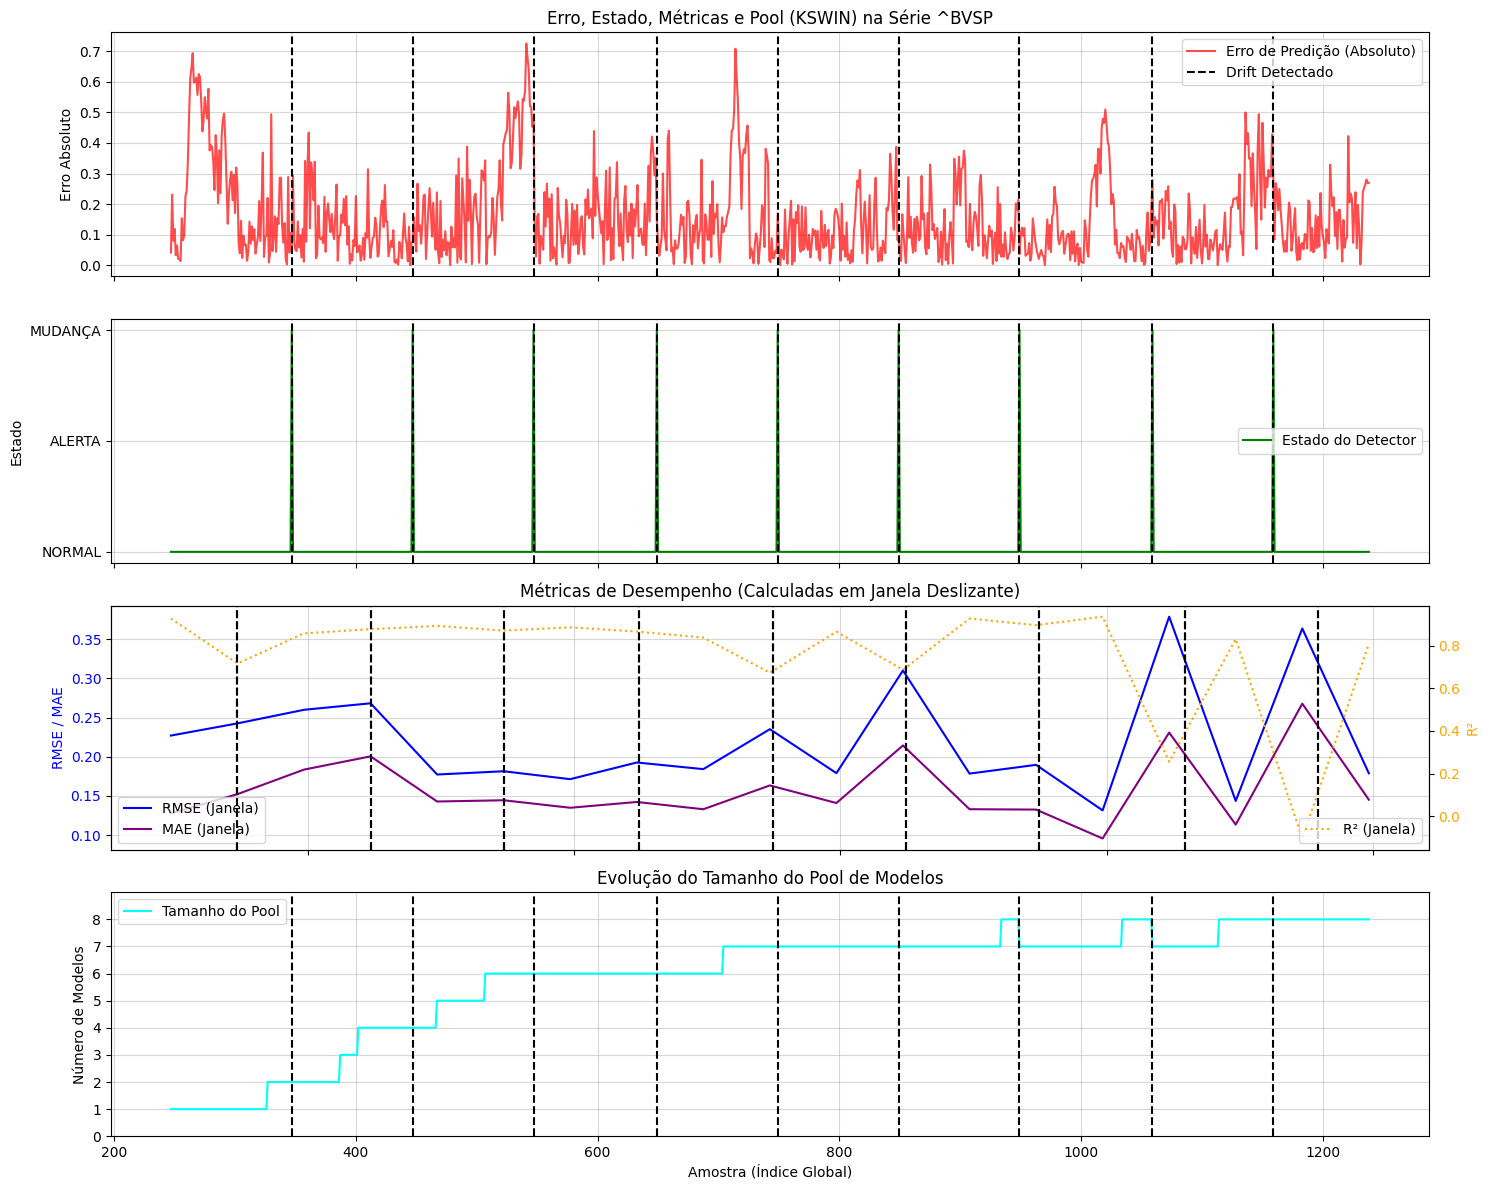


Métricas Globais no Stream:
  MSE: 0.0430
  MAE: 0.1562

Contagem de Uso dos Modelos Durante o Stream:
RandomForestModelo    992
Name: count, dtype: int64


In [15]:
print("\nGerando visualizações dos resultados...")
Visualizer.analisar_e_visualizar_resultados_stream(
    initial_size=initial_size,
    erros_predicao_stream=erros_predicao_stream,
    estados_detector_stream=estados_detector_stream,
    pontos_drift_detectados=pontos_drift_detectados,
    metricas_rmse_stream=metricas_rmse_stream,
    metricas_mae_stream=metricas_mae_stream,
    metricas_r2_stream=metricas_r2_stream,
    modelo_ativo_ao_longo_do_tempo=modelo_ativo_ao_longo_do_tempo,
    tamanho_pool_ao_longo_do_tempo=tamanho_pool_ao_longo_do_tempo,
    detector_escolhido=detector_escolhido,
    serie_escolhida=serie_escolhida
)


# 13.2 Previsão vs Real


Gerando gráfico de Previsões vs. Valores Reais...


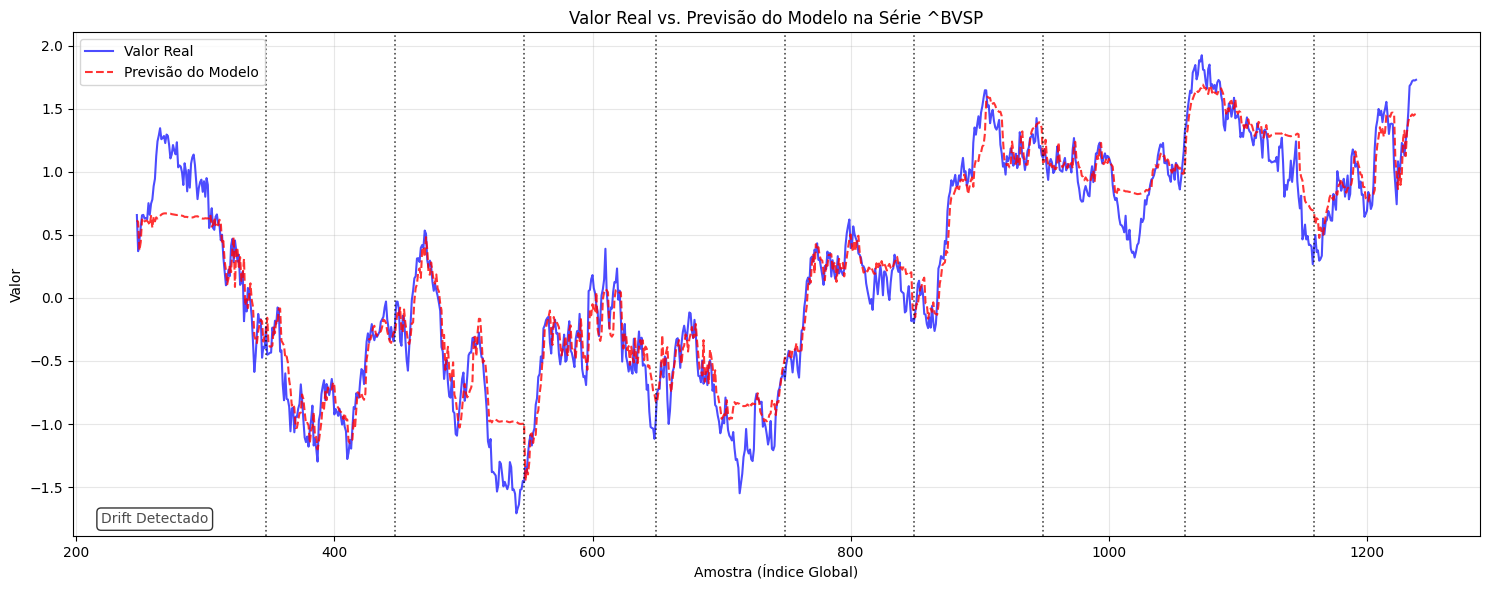

In [16]:
print("\nGerando gráfico de Previsões vs. Valores Reais...")
Visualizer.visualizar_previsoes_vs_real(
    initial_size=initial_size,
    Y_stream=Y_stream,
    predicoes_stream=predicoes_stream,
    pontos_drift_detectados=pontos_drift_detectados,
    serie_escolhida=serie_escolhida
)